# Multilevel Gravity Survey with MLDA

### Gravity Surveying
In this example, we solve the classical 1-dimensional gravity problem, as presented in Per Christian Hansen (2010) *Discrete Inverse Problems: Insight and Algorithms*. Society for Industrial and Applied Mathematics, January 2010. The forward model is a Fredholm integral of the first kind:

\begin{equation}
    \int_{0}^{1} K(s,t) f(t) = g(s), \quad 0 \le s \le 1,
\end{equation}
where $f(t)$ is an unknown mass distribution located at depth $d$ beneath the surface, $g(s)$ is the vertical component of the gravity field at the surface, and $K(s,t)$ is known as the *kernel*, which for this particular problem has the form
\begin{equation}
    K(s,t) = \frac{d}{(d^2 + (s-t)^2)^{\frac{3}{2}}}.
\end{equation}
Since $K(s,t) = h(s-t)$, this constitutes a special case of the generic Fredholm integral, known as a *deconvolution* problem.

We solve the integral using midpoint quadrature, so that in discrete form our forward model becomes
\begin{equation}
    \sum_{j=1}^{m} \omega_j K(s_i, t_j) \hat{f}(t_j) = g(s_i), \quad i = 1, \dots, n, \quad j = 1, \dots, m
\end{equation}
where $\omega_j$ are quadrature weights, $\hat{f}(t_j)$ is the approximate subsurface mass at quadrature points $j = 1, \dots, m$, and  $g(s_i)$ is surface measurements at collocation points $i = 1, \dots, n$. Hence when $n > m$, we are dealing with an overdetermined problem and vice versa. With $t \in [0,1]$, we have
\begin{equation}
    t_j = \frac{j-\frac{1}{2}}{m} \quad \textrm{and} \quad \omega_j = \frac{1}{m}
\end{equation}
This results in a linear system $\mathbf{Ax = b}$, where
\begin{equation}
    a_{ij} = \omega_j K(s_i, t_j), \quad x_j = \hat{f}(t_j), \quad b_i = g(s_i).
\end{equation}
In this particular problem, the matrix $\mathbf{A}$ has a very high condition number, leading to an ill-posed inverse problem, which entails numerical instability and spurious, often oscillatory, solutions for noisy right hand sides. These types of problems are traditionally solved by way of some manner of *regularisation*, but hey can be handled in a natural and elegant fashion in the context of a Bayesian inverse problem.

### Mass Distribution as a Gaussian Random Process
We model the unknown mass distribution as a Gaussian Random Process with a Matern 5/2 covariance kernel (Rasmussen and Williams, 2006):
\begin{equation}
    C_{5/2}(x, x') = \sigma^2 \left( 1 + \frac{\sqrt{5} \Vert x-x' \Vert _2 }{l} + \frac{5 \Vert x-x' \Vert _2^2}{3l^2} \right) \exp \left( - \frac{\sqrt{5} \Vert x-x' \Vert _2 }{l} \right)
\end{equation}
where $l$ is the covariance length scale, $\sigma^2$ is the variance and $\Vert \cdot \Vert_2$ is the L2 norm.

### References
Per Christian Hansen. *Discrete Inverse Problems: Insight and Algorithms*. Society for Industrial and Applied Mathematics, January 2010.

Carl Edward Rasmussen and Christopher K. I. Williams. *Gaussian processes for machine learning*. Adaptive computation and machine learning. 2006.

In [1]:
# Set the path to the modules holding random field class
import sys
sys.path.insert(1, 'mlda/')

In [2]:
# Restrict BLAS to operate on a single thread at a time,
# since multithreading doesn't play well with multiple parallel chains
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [3]:
# Import time for benchmarking
import time

# Get the essentials
import numpy as np
import matplotlib.pyplot as plt

# Get Matern52 kernel for modelling Gaussian Random Field
from RandomProcess import Matern52

# Get interpolator for projecting eigenmodes between model levels.
from scipy.interpolate import interp1d

# Get the good stuff.
import pymc3 as pm
import theano
import theano.tensor as tt

In [4]:
print('Theano version: {}'.format(theano.__version__))
print('PyMC3 version: {}'.format(pm.__version__))

Theano version: 1.0.4
PyMC3 version: 3.9.2


In [5]:
class Gravity:
    '''
    Gravity is a class that implements a simple gravity surveying problem,
    as described in Hansen, P. C. (2010). Discrete Inverse Problems: Insight and Algorithms. 
    Society for Industrial and Applied Mathematics.
    It uses midpoint quadrature to evaluate a Fredholm integral of the first kind.
    '''
    
    def __init__(self, f_function, depth, n_quadrature, datapoints):
        
        # Set the function describing the distribution of subsurface density.
        self.f_function = f_function
        
        # Set the depth of the density (distance to the surface measurements).
        self.d = depth
        
        # Set the quadrature degree.
        self.n = n_quadrature
        
        # Set the quadrature points.
        x = np.linspace(0,1,self.n+1)
        self.t = (x[1:] + x[:-1]) / 2
        
        # Set the quadrature weights.
        self.w = 1/self.n
        
        # Evaluate the density function on the quadrature points.
        self.f = self.f_function(self.t)
        
        # Set the measurement points.
        self.s = datapoints
        
        # Create the kernel of the discrete Fremholm integral.
        tt, ss = np.meshgrid(self.t, self.s)
        self.K = self.w*self.d / (self.d**2 + (ss-tt)**2)**(3/2)
        
        # Compute the surface density (noiseless measurements)
        self.g = np.dot(self.K, self.f)
    
    def plot_model(self):
        
        # Plot the density and the signal.
        fig, axes = plt.subplots(1,2, figsize=(12,4))
        axes[0].set_title('Density')
        axes[0].scatter(self.t, self.f)
        axes[1].set_title('Signal')
        axes[1].scatter(self.s, self.g)
        plt.show()
        
    def plot_kernel(self):
        
        # Plot the kernel.
        plt.figure(figsize=(8,6))
        plt.imshow(self.K); plt.colorbar()
        plt.show()

In [6]:
# This is the function, describing the subsurface density.
def f(t):
    f = np.sin(np.pi*t) + 0.5*np.sin(2*np.pi*t)
    return f

In [7]:
# Set the model parameters.
depth = 0.25
quadrature_degree = 64
n_data = 64
datapoints = np.linspace(0,1,n_data)

# Initialise a model
model_true = Gravity(f, depth, quadrature_degree, datapoints)

True Density, Signal and Noisy Measurements


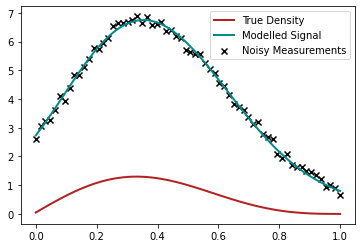

In [8]:
# Add noise to the data.
noise_level = 0.1

np.random.seed(123)
noise = np.random.normal(0, noise_level, n_data)
data = model_true.g + noise

# Plot density, noiseless signal and noisy measurements.
print('True Density, Signal and Noisy Measurements')
plt.figure(figsize=(6,4))
plt.plot(model_true.s, model_true.f, label='True Density', linewidth=2, c='firebrick')
plt.plot(model_true.s, model_true.g, label='Modelled Signal', linewidth=2, c='darkcyan')
plt.scatter(model_true.s, data, label='Noisy Measurements', c='k', marker='x')
plt.legend()
plt.show()

In [9]:
class Gravity_Forward(Gravity):
    '''
    Gravity forward is a class that implements the gravity problem,
    but computation of signal and density is delayed to the "solve"
    method, since it relied on a Gaussian Random Field to model
    the (unknown) density.
    '''
    def __init__(self, depth, n_quadrature, datapoints):
        
        # Set the depth of the density (distance to the surface measurements).
        self.d = depth
        
        # Set the quadrature degree.
        self.n = n_quadrature
        
        # Set the quadrature points.
        x = np.linspace(0,1,self.n+1)
        self.t = (x[1:] + x[:-1]) / 2
        
        # Set the quadrature weights.
        self.w = 1/self.n
        
        # Set the datapoints.
        self.s = datapoints
        
        # Create the kernel of the discrete Fremholm integral.
        tt, ss = np.meshgrid(self.t, self.s)
        self.K = self.w*self.d / (self.d**2 + (ss-tt)**2)**(3/2)
        
    def set_random_process(self, random_process, lamb, mkl):
        
        # Set the number of KL modes.
        self.mkl = mkl
        
        # Initialise a random process on the quadrature points.
        # and compute the eigenpairs of the covariance matrix,
        self.random_process = random_process(np.c_[self.t, np.zeros(len(self.t))], self.mkl, lamb)
        self.random_process.compute_eigenpairs()
    
    def solve(self, parameters):
        
        # Internalise the Random Field parameters
        self.parameters = parameters
        
        # Create a realisation of the random process, given the parameters.
        self.random_process.generate(self.parameters)
        mean = 0.0; stdev = 1.0;
        
        # Set the density.
        self.f = mean + stdev*self.random_process.random_field
        
        # Compute the signal.
        self.g = np.dot(self.K, self.f)
        
    def get_data(self):
        
        # Get the data vector.
        return self.g

In [10]:
# We project the eigenmodes of the fine model to the quadrature points
# of the coarse model using linear interpolation.
def project_eigenmodes(model_coarse, model_fine):
    model_coarse.random_process.eigenvalues = model_fine.random_process.eigenvalues 
    for i in range(model_coarse.mkl):
        interpolator = interp1d(model_fine.t, model_fine.random_process.eigenvectors[:,i])
        model_coarse.random_process.eigenvectors[:,i] = interpolator(model_coarse.t)

In [11]:
# Set random process parameters.
lamb = 0.2
mkl = 4

# Set the depth
depth = 0.25

# Set the quadrature degree for each model level (coarsest first)
n_quadrature = [16, 64]

# Initialise the models, according the quadrature degree.
my_models = []
for i, n_quad in enumerate(n_quadrature):
     my_models.append(Gravity_Forward(depth, n_quad, datapoints))
     my_models[i].set_random_process(Matern52, lamb, mkl)

Level 0:


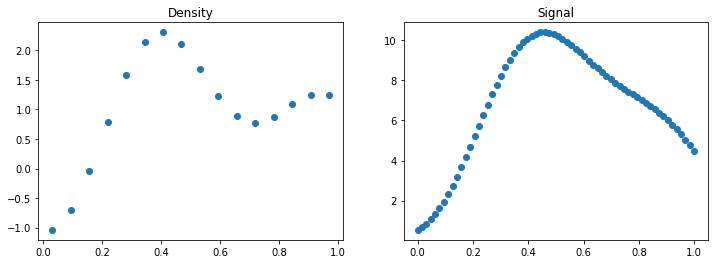

Level 1:


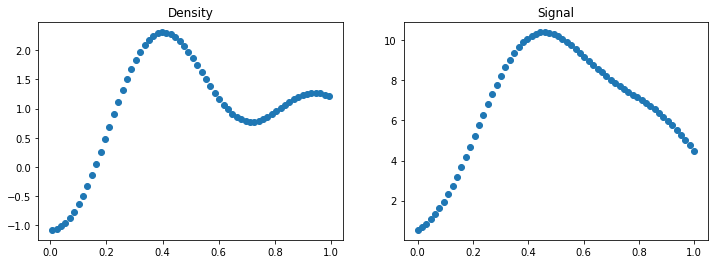

In [12]:
# Project the eigenmodes of the fine model to the coarse models.
for m in my_models[:-1]:
    project_eigenmodes(m, my_models[-1])

# Plot the same random realisation for each level, and the corresponding signal,
# to validate that the levels are equivalents.
for i, m in enumerate(my_models):
    print('Level {}:'.format(i))
    np.random.seed(0)
    m.solve(np.random.normal(size=mkl))
    m.plot_model()

In [13]:
# Number of draws from the distribution
ndraws = 5000

# Number of burn-in samples
nburn = 1000

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 100
discard_tuning = True

# Number of independent chains
nchains = 4

# Subsampling rate for MLDA
nsub = 8

# Do blocked/compounds sampling in Metropolis and MLDA 
# Note: This choice applies only to the coarsest level in MLDA 
# (where a Metropolis sampler is used), all other levels use block sampling
blocked = True

# Set prior parameters for multivariate Gaussian prior distribution.
mu_prior = np.zeros(mkl)
cov_prior = np.eye(mkl)

# Set the sigma for inference.
# Since there is some discrepancy between the fine and coarse models,
# we inflate the uncertainty of the coarse sampler slightly.
# This will not bias the resulting fine chain, since it is corrected
# by the second acceptance ratio.
sigma = [0.15, 0.1]

# Data generation seed
data_seed = 1234

# Sampling seed
sampling_seed = 1234

In [14]:
def my_loglik(my_model, theta, data, sigma):
    """
    This returns the log-likelihood of my_model given theta,
    datapoints, the observed data and sigma. It uses the
    model_wrapper function to do a model solve.
    """
    my_model.solve(theta)
    output = my_model.get_data()
    return - (0.5 / sigma ** 2) * np.sum((output - data) ** 2)

class LogLike(tt.Op):
    """
    Theano Op that wraps the log-likelihood computation, necessary to
    pass "black-box" fenics code into pymc3.
    Based on the work in:
    https://docs.pymc.io/notebooks/blackbox_external_likelihood.html
    https://docs.pymc.io/Advanced_usage_of_Theano_in_PyMC3.html
    """

    # Specify what type of object will be passed and returned to the Op when it is
    # called. In our case we will be passing it a vector of values (the parameters
    # that define our model and a model object) and returning a single "scalar"
    # value (the log-likelihood)
    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, my_model, loglike, data, sigma):
        """
        Initialise the Op with various things that our log-likelihood function
        requires. Below are the things that are needed in this particular
        example.

        Parameters
        ----------
        my_model:
            A Model object (defined in model.py) that contains the parameters
            and functions of out model.
        loglike:
            The log-likelihood function we've defined, in this example it is
            my_loglik.
        data:
            The "observed" data that our log-likelihood function takes in. These
            are the true data generated by the finest model in this example.
        x:
            The dependent variable (aka 'x') that our model requires. This is
            the datapoints in this example.
        sigma:
            The noise standard deviation that our function requires.
        """
        # add inputs as class attributes
        self.my_model = my_model
        self.likelihood = loglike
        self.data = data
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(self.my_model, theta, self.data, self.sigma)

        outputs[0][0] = np.array(logl) # output the log-likelihood

In [15]:
# create Theano Ops to wrap likelihoods of all model levels and store them in list
logl = []
for i, m_i in enumerate(my_models):
    logl.append(LogLike(m_i, my_loglik, data, sigma[i]))

In [16]:
# Set up models in pymc3 for each level - excluding finest model level
coarse_models = []
for j in range(len(my_models) - 1):
    with pm.Model() as model:
        
        # Multivariate normal prior distribution
        theta = pm.MvNormal('theta', mu=mu_prior, cov=cov_prior, shape=mkl)
        
        # Use the Potential class to evaluate likelihood (DensityDist appears to be broken)
        pm.Potential('likelihood', logl[j](theta))
        
    coarse_models.append(model)

/home/mikkel/venv/pymc3_mlda/lib/python3.6/site-packages/pymc3/step_methods/metropolis.py:993: UserWarning: The MLDA implementation in PyMC3 is very young. You should be extra critical about its results.
  'The MLDA implementation in PyMC3 is very young. '
Multiprocess sampling (4 chains in 4 jobs)
MLDA: [theta]


/home/mikkel/venv/pymc3_mlda/lib/python3.6/site-packages/pymc3/sampling.py:431: UserWarning: Tuning samples will be included in the returned `MultiTrace` object, which can lead to complications in your downstream analysis. Please consider to switch to `InferenceData`:
`pm.sample(..., return_inferencedata=True)`
  UserWarning
/home/mikkel/venv/pymc3_mlda/lib/python3.6/site-packages/pymc3/sampling.py:431: UserWarning: Tuning samples will be included in the returned `MultiTrace` object, which can lead to complications in your downstream analysis. Please consider to switch to `InferenceData`:
`pm.sample(..., return_inferencedata=True)`
  UserWarning
/home/mikkel/venv/pymc3_mlda/lib/python3.6/site-packages/pymc3/sampling.py:431: UserWarning: Tuning samples will be included in the returned `MultiTrace` object, which can lead to complications in your downstream analysis. Please consider to switch to `InferenceData`:
`pm.sample(..., return_inferencedata=True)`
  UserWarning
/home/mikkel/venv/p


MLDA Sampler: 5000 drawn samples in each of 4 chains.
Runtime: 99.23791742324829 seconds
Acceptance rate: 0.558
ESS list: [9416.11365821 6848.78474137 2948.36433542  663.47303229]
Normalised ESS list: [0.47080568 0.34243924 0.14741822 0.03317365]
ESS/sec: [94.88423279 69.01378948 29.71005853  6.68568073]

MAP estimate: [ 1.07744272 -0.62728718  0.31152603  0.45072083]
Summary:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
theta[0]  1.077  0.003   1.072    1.084      0.000    0.000    9406.0  9406.0   
theta[1] -0.627  0.006  -0.638   -0.616      0.000    0.000    6848.0  6848.0   
theta[2]  0.312  0.013   0.286    0.336      0.000    0.000    2949.0  2949.0   
theta[3]  0.453  0.033   0.388    0.512      0.001    0.001     663.0   663.0   

          ess_bulk  ess_tail  r_hat  
theta[0]    9416.0   10369.0   1.00  
theta[1]    6849.0    9109.0   1.00  
theta[2]    2948.0    5054.0   1.00  
theta[3]     663.0    1159.0   1.01  

Trace and Marginal Di

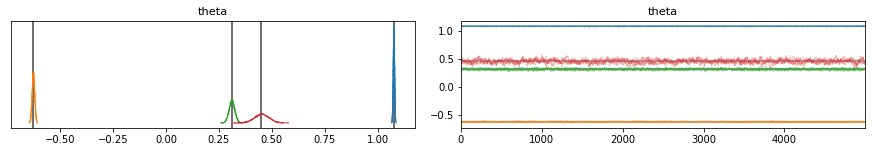

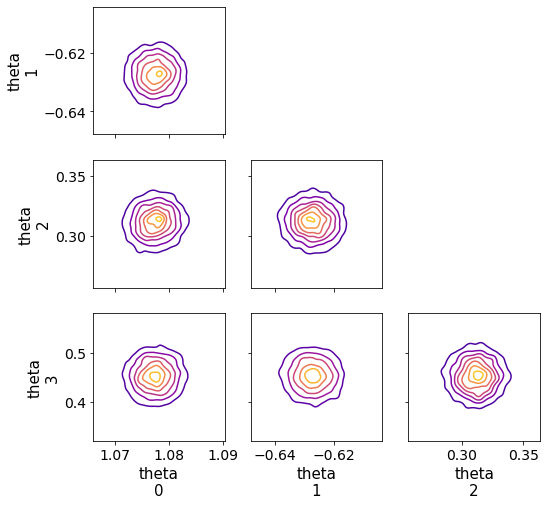

In [17]:
# Set up finest model and perform inference with PyMC3, using the MLDA algorithm
# and passing the coarse_models list created above.

with pm.Model():
    
    # Multivariate normal prior.
    theta = pm.MvNormal('theta', mu=mu_prior, cov=cov_prior, shape=mkl)
    
    # Use the Potential class to evaluate likelihood (DensityDist appears to be broken)
    pm.Potential('likelihood', logl[-1](theta))
    
    # Find the MAP estimate for convergence diagnostics. 
    # It is NOT used as starting point for sampling.
    MAP = pm.find_MAP()
    
    # Initialise an MLDA step method object, passing the subsampling rate and
    # coarse models list
    step_mlda = pm.MLDA(subsampling_rates=nsub, coarse_models=coarse_models,
                        tune=tune, tune_interval=tune_interval, base_blocked=blocked)

    # Inference!
    t_start = time.time()
    trace   = pm.sample(draws=ndraws, step=step_mlda,
                            chains=nchains, tune=nburn,
                            discard_tuned_samples=discard_tuning,
                            random_seed=sampling_seed)
    runtime = time.time() - t_start
    
    # Print some diagnostics.
    ess = pm.ess(trace).theta.values
    means = pm.stats.summary(trace)['mean']
    print(f'\nMLDA Sampler: {len(trace)} drawn samples in each of '
              f'{trace.nchains} chains.'
              f'\nRuntime: {runtime} seconds'
              f'\nAcceptance rate: {trace.get_sampler_stats("accepted").mean()}'
              f'\nESS list: {ess}'
              f'\nNormalised ESS list: {ess / len(trace) / trace.nchains}'
              f'\nESS/sec: {ess / runtime}')
    
    # Print the MAP point and parameter summaries.
    print(f'\nMAP estimate: {MAP["theta"]}\nSummary:\n', pm.stats.summary(trace))
    
    print('\nTrace and Marginal Distributions:')
    pm.plots.traceplot(trace, lines=(('theta',{}, MAP['theta'].tolist()),))
    
    pm.plots.pairplot(trace, kind='kde', figsize=(8,8), 
                      kde_kwargs={'contour': True, 
                                  'contour_kwargs':{'colors':None, 'cmap':plt.cm.plasma},
                                  'contourf_kwargs':{'alpha':0}})

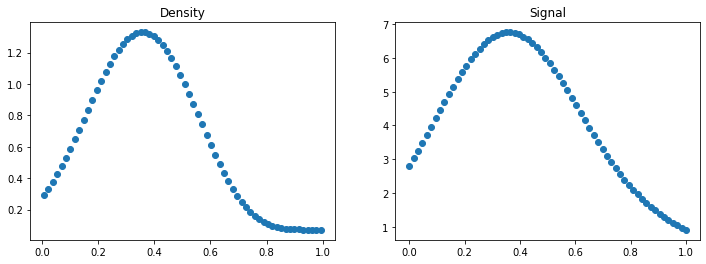

In [18]:
my_models[-1].solve(means.values)
my_models[-1].plot_model()